In [60]:
# import system libraries
import os
import PIL
from PIL import Image
import cv2
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import EfficientNetB3

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#### Data preprocessing

##### Read Data and store it in dataframe

In [62]:
data_dir = 'archive/flower_photos'
filepaths = []
labels = []

folders = os.listdir(data_dir)
for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [261]:
df

filepaths  labels
0     archive — kopia/flower_photos\daisy\004233843c...   daisy
1     archive — kopia/flower_photos\daisy\008a9b32e1...   daisy
2     archive — kopia/flower_photos\daisy\00ab95b530...   daisy
3     archive — kopia/flower_photos\daisy\013ed1e00b...   daisy
4     archive — kopia/flower_photos\daisy\021f5f0616...   daisy
...                                                 ...     ...
8750  archive — kopia/flower_photos\tulips\tulips-fl...  tulips
8751  archive — kopia/flower_photos\tulips\tulips-fl...  tulips
8752  archive — kopia/flower_photos\tulips\tulips-ga...  tulips
8753  archive — kopia/flower_photos\tulips\tulips-ne...  tulips
8754  archive — kopia/flower_photos\tulips\white-tul...  tulips

[8755 rows x 2 columns]

In [66]:
df['labels'].value_counts()

labels
roses         1752
tulips        1752
sunflowers    1751
daisy         1750
dandelion     1750
Name: count, dtype: int64

##### Spliting the data into Training and Testing

In [263]:
# Splitting dataset
strat = df['labels']
train_df, temp_df = train_test_split(df, 
                                    test_size=.2, 
                                    random_state=42, 
                                    stratify=strat, 
                                    shuffle=True)

# valid and test dataframe
strat = temp_df['labels']
valid_df, test_df = train_test_split(temp_df, 
                                     test_size=.5, 
                                     random_state=42, 
                                     stratify=strat, 
                                     shuffle=True)

print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

train_df

Number of Training dataset: 7004
Number of Validation dataset: 875
Number of Testing dataset: 876


filepaths      labels
6423  archive — kopia/flower_photos\sunflowers\fa828...  sunflowers
6731  archive — kopia/flower_photos\sunflowers\pxcli...  sunflowers
8717  archive — kopia/flower_photos\tulips\tulips-47...      tulips
3625  archive — kopia/flower_photos\roses\145862135_...       roses
613   archive — kopia/flower_photos\daisy\506018088_...       daisy
...                                                 ...         ...
4771  archive — kopia/flower_photos\roses\pexels-pho...       roses
3408  archive — kopia/flower_photos\dandelion\pexels...   dandelion
6174  archive — kopia/flower_photos\sunflowers\7ed77...  sunflowers
4760  archive — kopia/flower_photos\roses\pexels-pho...       roses
4136  archive — kopia/flower_photos\roses\4654893119...       roses

[7004 rows x 2 columns]

#### Create image data generator

In [265]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Updated generator for training data
tr_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalization of pixels to the range [0, 1]
    rotation_range=30,          # Smaller rotations
    width_shift_range=0.1,      # Smaller width shifts
    height_shift_range=0.1,     # Smaller height shifts
    shear_range=0.2,            # Smaller shear range
    zoom_range=0.2,             # Subtle zoom
    horizontal_flip=True,       # Random horizontal flip
    brightness_range=[0.8, 1.2],  # More subtle brightness changes
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(
    rescale=1.0 / 255.0  # Normalization of pixels to the range [0, 1]
)

# Data generators
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 6365 validated image filenames belonging to 5 classes.
Found 779 validated image filenames belonging to 5 classes.
Found 803 validated image filenames belonging to 5 classes.


##### Show sample from train data

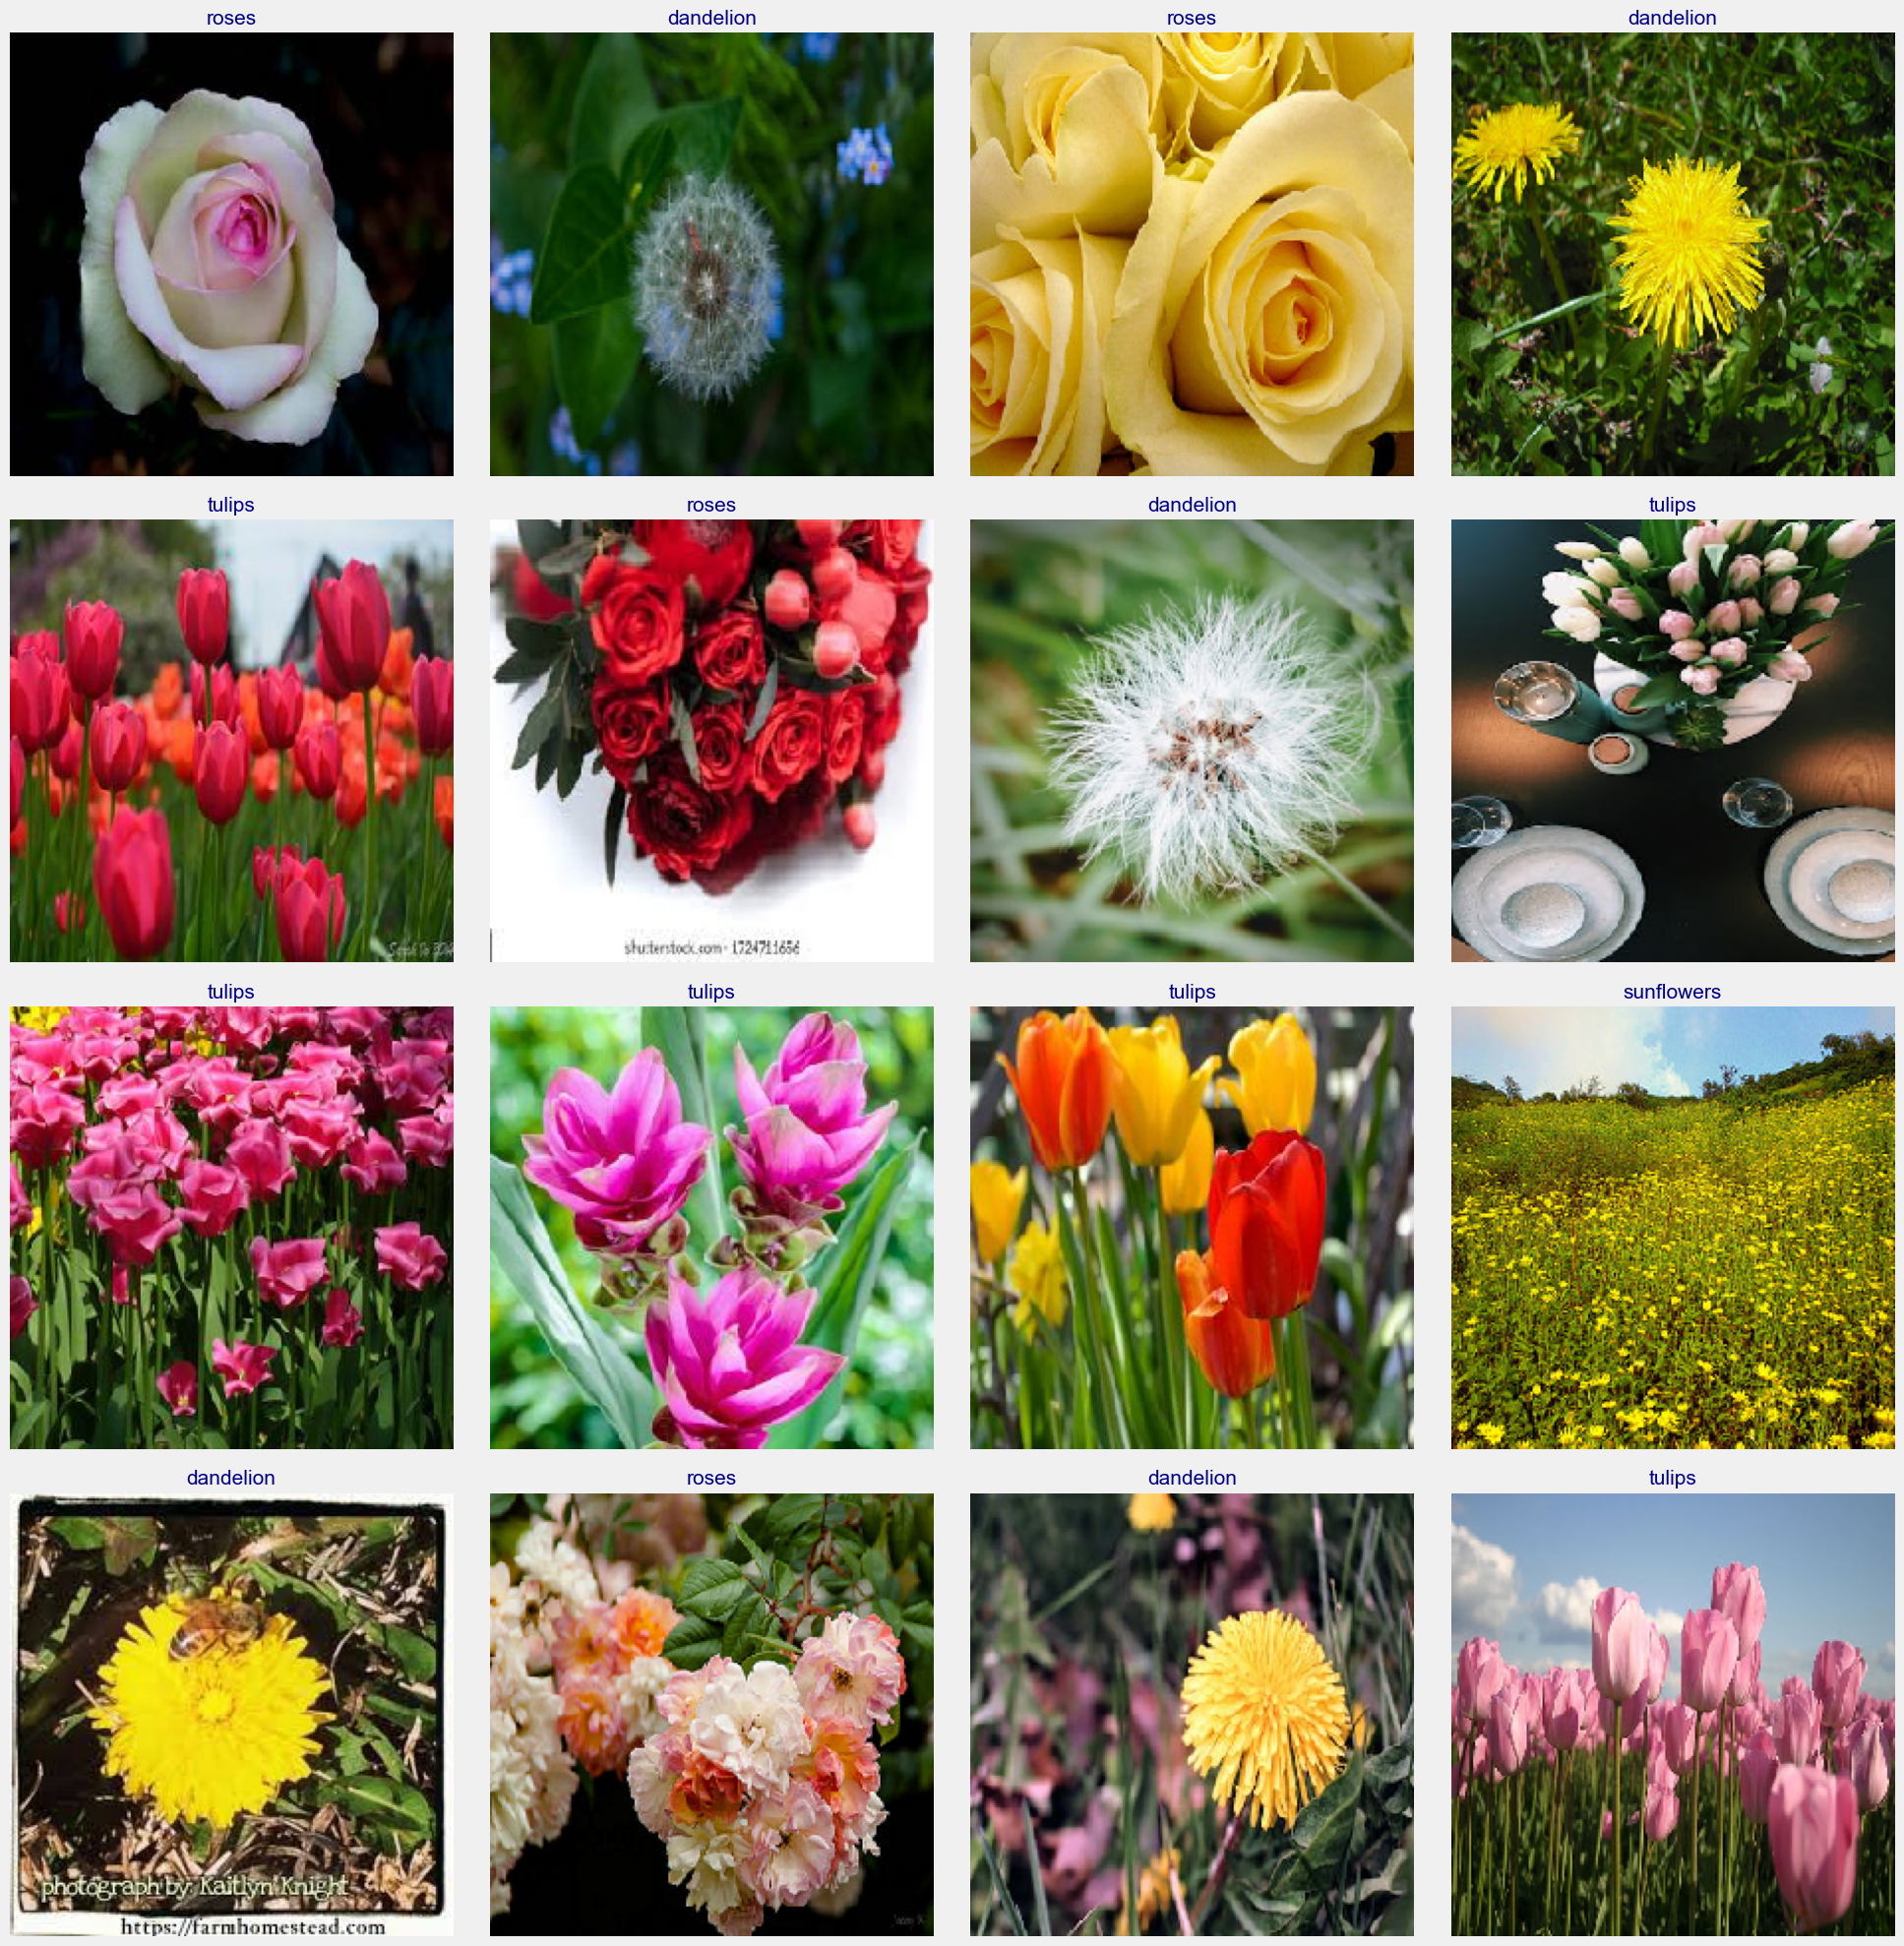

In [271]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())
images, labels = next(valid_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='darkblue', fontsize=15)
    plt.axis('off')
plt.tight_layout()
plt.show()


### Model Structure

#### Generic Model Creation

In [273]:
from tensorflow.keras.applications import MobileNetV2

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


base_model = MobileNetV2(
    include_top=False, 
    weights='imagenet',
    input_shape=img_shape, 
    pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(rate=0.45),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(rate=0.45),  
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate= .0001), 
              loss = 'categorical_crossentropy', 
              metrics=['acc', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       tf.keras.metrics.AUC()])

#### Train Model

In [275]:
early_stopping = EarlyStopping(patience=10,
                               min_delta=0,
                               mode=min,
                               monitor='val_loss',
                               verbose=0,
                               restore_best_weights=True,
                               baseline=None
                              )

In [277]:
history = model.fit(train_gen, 
                    epochs=30, 
                    verbose=1,
                    alidation_data=valid_gen, 
                    validation_steps= None, 
                    shuffle=False, 
                    callbacks=early_stopping
                   )

Epoch 1/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - acc: 0.3488 - auc_2: 0.6579 - loss: 7.7996 - precision_2: 0.3826 - recall_2: 0.2549 - val_acc: 0.7291 - val_auc_2: 0.9354 - val_loss: 6.5558 - val_precision_2: 0.7933 - val_recall_2: 0.6354
Epoch 2/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - acc: 0.6858 - auc_2: 0.9150 - loss: 6.6476 - precision_2: 0.7463 - recall_2: 0.6274 - val_acc: 0.8408 - val_auc_2: 0.9782 - val_loss: 6.1419 - val_precision_2: 0.8667 - val_recall_2: 0.8177
Epoch 3/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - acc: 0.7975 - auc_2: 0.9612 - loss: 6.2460 - precision_2: 0.8402 - recall_2: 0.7604 - val_acc: 0.8716 - val_auc_2: 0.9892 - val_loss: 5.8984 - val_precision_2: 0.8935 - val_recall_2: 0.8614
Epoch 4/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - acc: 0.8478 - auc_2: 0.9742 - loss: 6.0081 - precision_2: 0.8773 - recall_2: 0.8247 - val_acc: 0.9089 - val_auc_2: 0.9935 - val_loss: 5.6922 - val_precision_2: 0.9221 - val_recall_2: 0.8960
Epoch 5/30
199/199 ━

#### Display model performance

In [281]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
tr_perc = history.history['precision_2']
tr_recall = history.history['recall_2']
tr_auc = history.history['auc_2']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
val_perc = history.history['val_precision_2']
val_recall = history.history['val_recall_2']
val_auc = history.history['val_auc_2']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

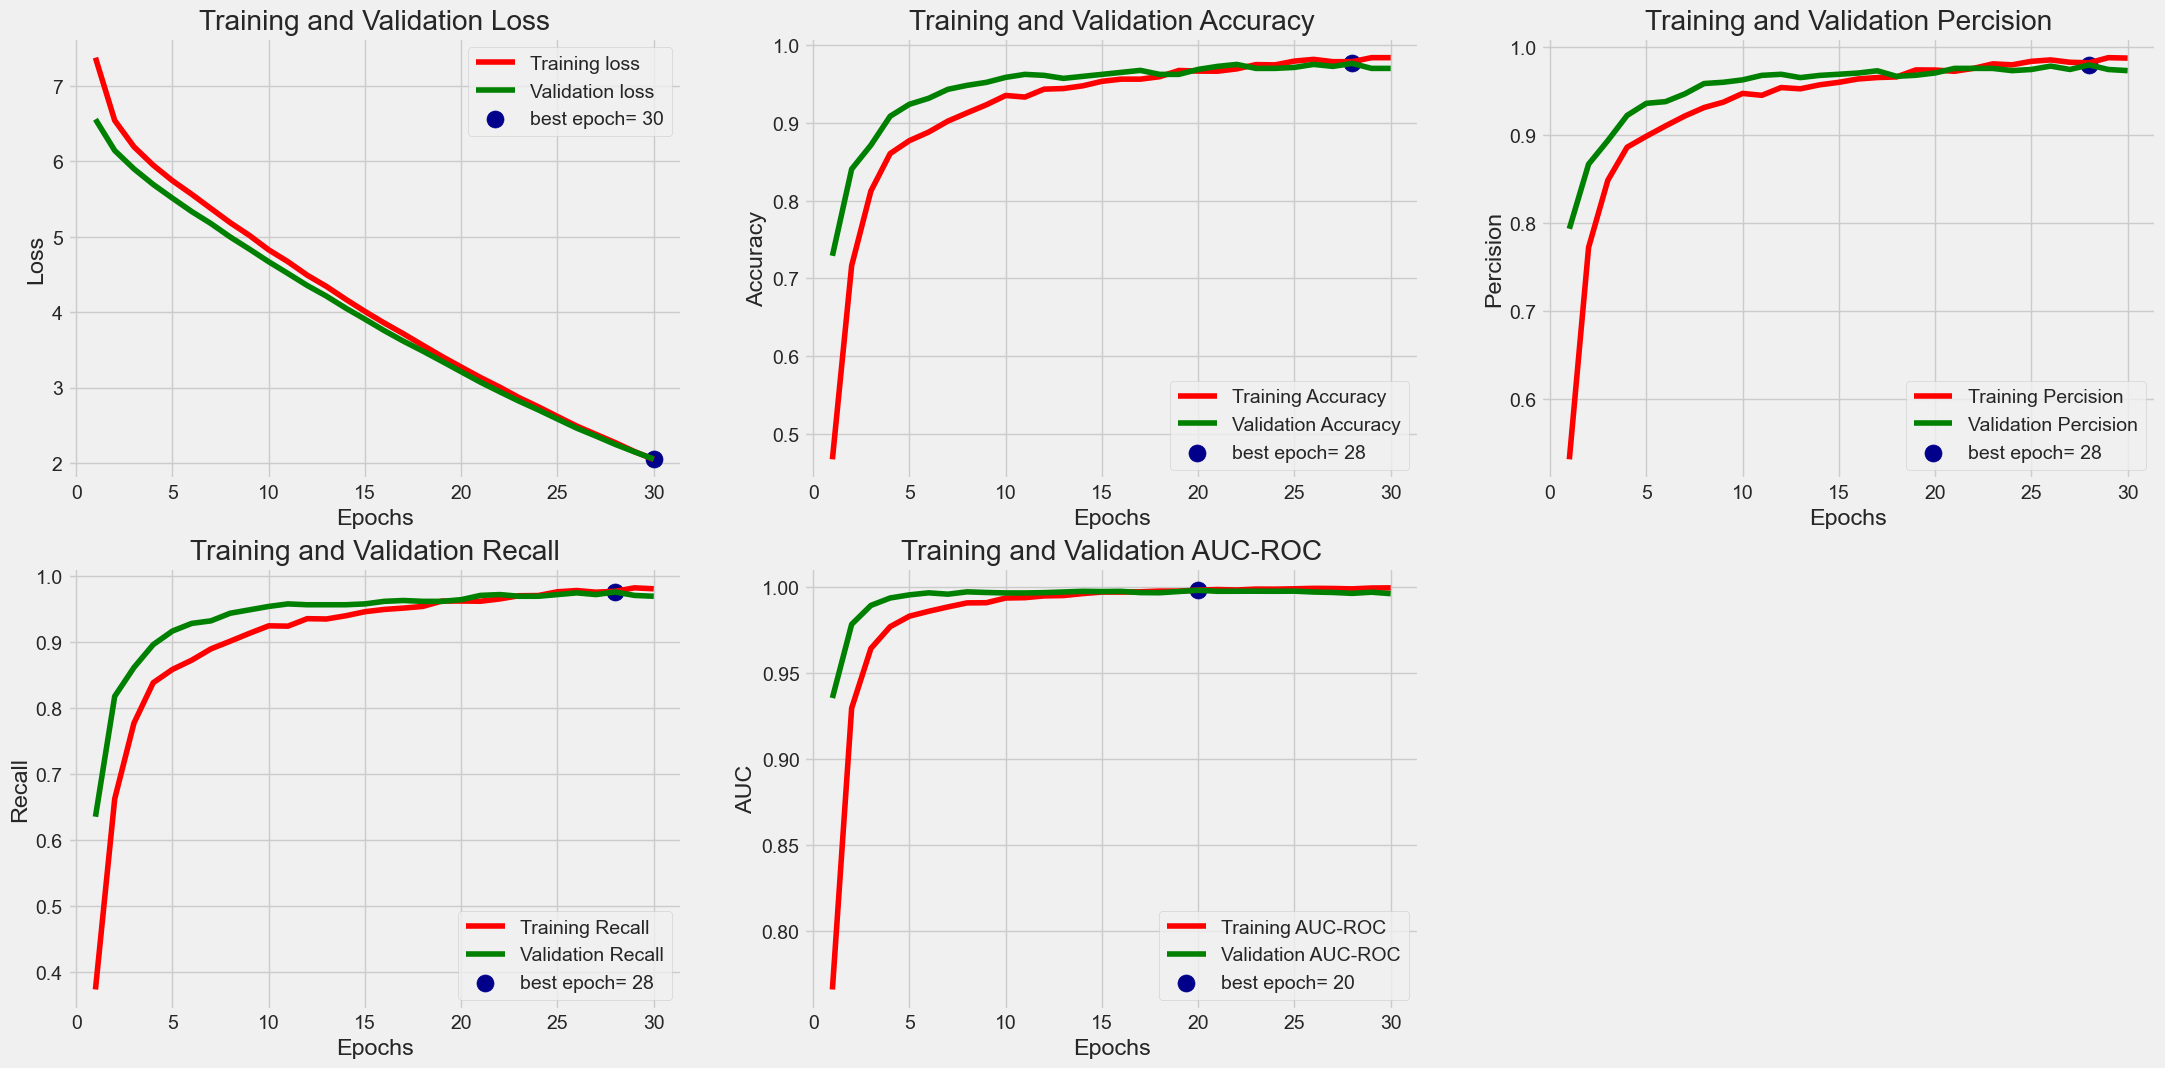

In [283]:
# Plot training history
plt.figure(figsize= (24, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label= 'Training Percision')
plt.plot(Epochs, val_perc, 'g', label= 'Validation Percision')
plt.scatter(index_perc + 1 , perc_highest, s= 150, c= 'darkblue', label= perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label= 'Training Recall')
plt.plot(Epochs, val_recall, 'g', label= 'Validation Recall')
plt.scatter(index_recall + 1 , recall_highest, s= 150, c= 'darkblue', label= recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label= 'Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label= 'Validation AUC-ROC')
plt.scatter(index_auc + 1 , auc_highest, s= 150, c= 'darkblue', label= auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout
plt.show()

#### Evaluate model

In [285]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

199/199 ━━━━━━━━━━━━━━━━━━━━ 151s 759ms/step - acc: 0.9966 - auc_2: 1.0000 - loss: 1.9577 - precision_2: 0.9968 - recall_2: 0.9965
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - acc: 0.9681 - auc_2: 0.9973 - loss: 2.0549 - precision_2: 0.9708 - recall_2: 0.9675
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 519ms/step - acc: 0.9732 - auc_2: 0.9975 - loss: 2.0364 - precision_2: 0.9737 - recall_2: 0.9715
Train Loss:  1.9562197923660278
Train Accuracy:  0.9971720576286316
--------------------
Validation Loss:  2.0534918308258057
Validation Accuracy:  0.9704749584197998
--------------------
Test Loss:  2.0140957832336426
Test Accuracy:  0.9775840640068054


#### temperature scaling

In [287]:
# Temperature Scaling - applying calibration
T = 2.0
logits = model.predict(test_gen, verbose=1)  # Obtaining logits from the model
calibrated_probs = tf.nn.softmax(logits / T, axis=-1)  # Calibrated probabilities

# Predicted classes after calibration
calibrated_preds = np.argmax(calibrated_probs, axis=-1)

# Comparison with true labels
true_labels = test_gen.classes

from sklearn.metrics import classification_report
print("Results after calibration with Temperature Scaling:")
print(classification_report(true_labels, calibrated_preds, target_names=test_gen.class_indices.keys()))


26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 542ms/step
Wyniki po kalibracji z Temperature Scaling:
              precision    recall  f1-score   support

       daisy       0.99      0.98      0.99       151
   dandelion       0.98      0.98      0.98       162
       roses       0.97      0.97      0.97       155
  sunflowers       0.98      0.99      0.99       168
      tulips       0.97      0.96      0.97       167

    accuracy                           0.98       803
   macro avg       0.98      0.98      0.98       803
weighted avg       0.98      0.98      0.98       803



#### Get Predictions

In [289]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 491ms/step


#### Confusion Matrics and Classification Report

In [291]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [293]:
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[148,   2,   0,   0,   1],
       [  1, 158,   0,   2,   1],
       [  0,   0, 151,   1,   3],
       [  0,   1,   0, 167,   0],
       [  0,   1,   5,   0, 161]], dtype=int64)

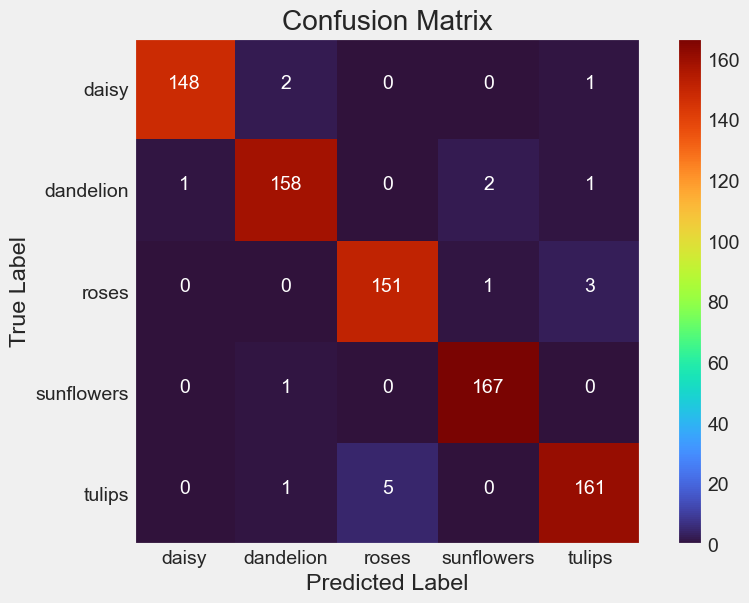

In [295]:
plt.figure(figsize= (8, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.turbo)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 0)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white')# if cm[i, j] > thresh else 'black')

plt.grid(False)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [297]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       daisy       0.99      0.98      0.99       151
   dandelion       0.98      0.98      0.98       162
       roses       0.97      0.97      0.97       155
  sunflowers       0.98      0.99      0.99       168
      tulips       0.97      0.96      0.97       167

    accuracy                           0.98       803
   macro avg       0.98      0.98      0.98       803
weighted avg       0.98      0.98      0.98       803



#### Save model

In [299]:
output_folder = "path/to/save_model"
model_save_path = os.path.join(output_folder, "model.keras")

model.save(model_save_path)  # TensorFlow format

Model zapisany w formacie TensorFlow w: C:/Users/dwlod/Desktop/SEM_II_mgr/CPO/projekt/Flower MobileNetv2 5.keras


### Predykcja z wczytaniem modelu

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Wczytaj model
model = load_model('taht/to/model.keras')

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    resized_image = cv2.resize(image, target_size)  # Resize to the target size
    processed_image = resized_image / 255.0  # Normalize pixel values to the range [0, 1]
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
    return processed_image, image

# Function to make predictions
def predict_image(image_path, model, class_labels):
    processed_image, original_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)  # Get model predictions
    predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
    confidence = np.max(predictions)  # Get the confidence of the prediction
    return predicted_class[0], confidence, predictions[0], original_image

# Define the class labels for the model
class_labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Ścieżka do folderu z obrazami
folder_path = "path/to/test_imag_folder"

# Get paths to all images in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Iterate over images and perform predictions
for image_path in image_files:
    try:
        # Make prediction for the current image
        predicted_class, confidence, predictions, original_image = predict_image(image_path, model, class_labels)

        # Sort class probabilities in descending order
        sorted_indices = np.argsort(predictions)[::-1]
        sorted_predictions = [(class_labels[i], predictions[i] * 100) for i in sorted_indices]

        # Display the image and predictions
        plt.figure(figsize=(7, 5))
        plt.imshow(original_image)
        plt.title(f"This flower is: {class_labels[predicted_class]}", fontsize=20)
        plt.axis('off')

        # Add confidence percentages for all classes (sorted by probability)
        y_offset = 0.6  # Initial position for text on the Y-axis
        for label, prob in sorted_predictions:
            plt.text(
                1.02,  # X-axis position (outside the image)
                y_offset,  # Y-axis position
                f"{label}: {prob:.2f}%",  # Class name and probability
                fontsize=12,
                transform=plt.gca().transAxes
            )
            y_offset -= 0.05  # Move text down for the next class

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"Error for image {image_path}: {e}")